# Wildfire Fire Detection from Satellite Imagery 

## Imported Libraries

In [2]:
#Import Libraries
import os
import time
import pandas as pd
import numpy as np
import cv2 
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2024-02-05 13:51:03.000971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## User Defined Functions

### Function to Load Image

In [4]:
#Function to Load image and visualize it
# Load the image with OpenCV

def load_image(imagePath):
    """
    Loads an image from a path, plots it and returns a NumPy array.

    Args:
        imagePath (str): Path to the image file.

    Returns:
        np.ndarray: The loaded image as a NumPy array.
    """

    start_time = time.time()

    image_a = cv2.imread(imagePath)
    image = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)
   
    # Display the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print(f"Loading time: {time.time() - start_time:.2f} seconds")
    return image

### Function to Tile Image

In [5]:
# Tile Image 
def tile_image(height, width, overlap):
    '''
    Decription : A function to tile an image based on a specified length and width,
                    define an overlap and loop through it to append to the tile array
    Param:int : height
          int : width
          int : overlap
    Returns : returns an array of tiles
    '''
    start_time = time.time()
    tiles = []
    ## Define the tile size
    tile_size = (height, width)

    # Calculate the number of tiles in each dimension
    num_tiles_height = height // tile_size[0]
    num_tiles_width = width // tile_size[1]
    
    # Define the stride (amount of overlap)
    overlap = 20  # Adjust this value based on your desired overlap amount

    # Iterate over the tiles and extract each 64x64 patch with overlap
    tiles = []
    for i in range(0, image.shape[0] - tile_size[0] + 1, overlap):
        for j in range(0, image.shape[1] - tile_size[1] + 1, overlap):
            tile = image[i : i + tile_size[0], j : j + tile_size[1]]
            tiles.append(tile)
    print(f"Tiling time: {time.time() - start_time:.2f} seconds")
    return tiles
    

### Function to Shuffle Image

### Function to Normalize Image tiles to [0, 1]

In [6]:
def normalize_tiles(tiles, smooth=1e-20):
    """
    Normalizes each tile in a list to have values between 0 and 1.

    Args:
        tiles (list): List of NumPy arrays representing individual tiles.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1e-20.

    Returns:
        list: List of normalized NumPy arrays with the same shape as the original tiles.
    """
    start_time = time.time()
    normalized_tiles = []
    for tile in tiles:
        # Convert to NumPy array if needed
        if not isinstance(tile, np.ndarray):
            tile = np.asarray(tile, dtype=np.float64)

        # Calculate min and max values for this tile
        min_value = np.min(tile)
        max_value = np.max(tile)

        # Normalize within tile, ensuring values between 0 and 1
        normalized_tile = (tile - min_value) / (max_value - min_value + smooth)
        normalized_tile = np.clip(normalized_tile, 0, 1)

        normalized_tiles.append(normalized_tile)
    print(f"Normalization time: {time.time() - start_time:.2f} seconds")
    return normalized_tiles

## Load Satellite Imagery

### Image path specification

In [7]:
#Specify Image path
imagePath = 'wildfirefromspace.jpeg'

### Load image using loadImg(imagePath)

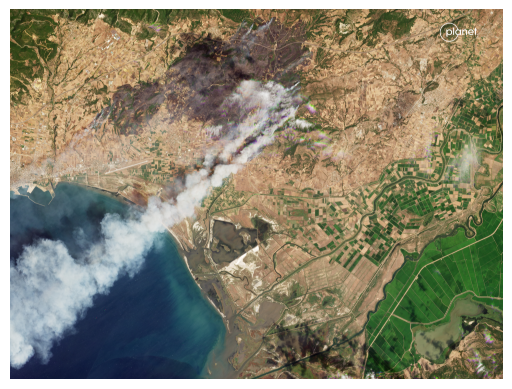

Loading time: 3.80 seconds


In [8]:
#Load and Specify image
image = load_image(imagePath) 

### Image dimention

In [9]:
## Image shape
print(f"Image shape : {image.shape}")

Image shape : (6144, 8192, 3)


### View Image matrix

In [10]:
# Visualize Image matrix
print(image)

[[[ 55  63  16]
  [ 65  73  26]
  [ 70  75  34]
  ...
  [156 111  80]
  [157 114  80]
  [158 115  81]]

 [[ 52  59  15]
  [ 63  70  26]
  [ 70  75  34]
  ...
  [156 111  78]
  [156 113  79]
  [157 114  80]]

 [[ 52  59  17]
  [ 53  58  17]
  [ 61  63  23]
  ...
  [156 113  78]
  [159 116  81]
  [160 117  82]]

 ...

 [[ 24  33  66]
  [ 21  30  63]
  [ 23  29  65]
  ...
  [121 104  78]
  [129 105  79]
  [112  84  60]]

 [[ 21  31  66]
  [ 21  29  65]
  [ 23  29  65]
  ...
  [100  85  56]
  [109  87  64]
  [105  78  59]]

 [[ 21  31  66]
  [ 21  31  66]
  [ 24  29  67]
  ...
  [102  89  57]
  [104  82  61]
  [104  77  60]]]


## Image Preprocessing

### Tile image 

In [11]:
# Tile images
height = 2048
width = 2048
overlap = 0
tiles = tile_image(height, width, overlap)

Tiling time: 0.07 seconds


### Tile Dimention 

In [12]:
## Tile shape
print(f"Image shape : {tiles[1000].shape}")

Image shape : (2048, 2048, 3)


### View number of tiles in tiles[ ]

In [13]:
# Number of items in list
print(len(tiles))

63140


### Visualize Matrix of any random tile, tiles[n] where n = arrIDX

In [14]:
print(tiles[10])

[[[ 93  90  49]
  [103 100  59]
  [ 91  92  52]
  ...
  [ 64  71  30]
  [ 81  84  41]
  [ 85  86  44]]

 [[ 94  91  50]
  [106 103  62]
  [100 102  62]
  ...
  [ 51  58  17]
  [ 65  68  25]
  [ 81  82  40]]

 [[ 90  86  48]
  [101  98  57]
  [ 94  97  54]
  ...
  [ 54  62  23]
  [ 61  63  23]
  [ 69  70  30]]

 ...

 [[193 165 128]
  [186 154 113]
  [173 144 100]
  ...
  [213 188 157]
  [215 190 159]
  [202 177 146]]

 [[192 158 123]
  [191 153 116]
  [191 156 118]
  ...
  [213 188 157]
  [209 185 151]
  [199 174 143]]

 [[191 158 123]
  [193 158 120]
  [194 162 124]
  ...
  [209 184 153]
  [202 177 146]
  [198 173 142]]]


### Plot  any random tile, tiles[n] where n = arrIDX

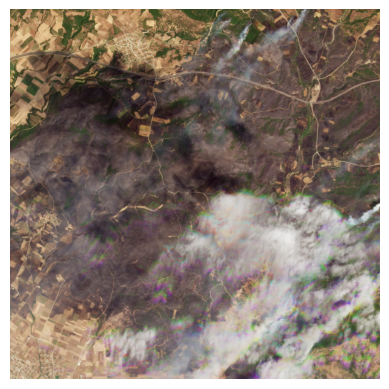

In [15]:
#Visualize the first tile
# Display the image using matplotlib
plt.imshow(tiles[2600])
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [16]:
print(f"tile shape : {tiles[0].shape}")

tile shape : (2048, 2048, 3)


### Normalize each tile to values [0, 1]

In [1]:
normalized_tiles = normalize_tiles(tiles, smooth=1e-20)

NameError: name 'normalize_tiles' is not defined

### Randomize / Shuffle image